###### **Deep Learning Project: Street View Housing Number Digit Recognition**

# **Marks: 60**

--------------
## **Context** 
--------------

One of the most interesting tasks in deep learning is to recognize objects in natural scenes. The ability to process visual information using machine learning algorithms can be very useful as demonstrated in various applications.

The SVHN dataset contains over 600,000 labeled digits cropped from street-level photos. It is one of the most popular image recognition datasets. It has been used in neural networks created by Google to improve the map quality by automatically transcribing the address numbers from a patch of pixels. The transcribed number with a known street address helps pinpoint the location of the building it represents. 

----------------
## **Objective**
----------------

Our objective is to predict the number depicted inside the image by using Artificial or Fully Connected Feed Forward Neural Networks and Convolutional Neural Networks. We will go through various models of each and finally select the one that is giving us the best performance. 

-------------
## **Dataset**
-------------
Here, we will use a subset of the original data to save some computation time. The dataset is provided as a .h5 file. The basic preprocessing steps have been applied on the dataset.

## **Mount the drive**

Let us start by mounting the Google drive. You can run the below cell to mount the Google drive.

In [ ]:
# I installed the .h5 file locally instead of referencing it from the Drive

## **Importing the necessary libraries**

In [41]:
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, LeakyReLU, MaxPooling2D, Flatten
from tensorflow.keras import backend
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

**Let us check the version of tensorflow.**

In [2]:
print("Tensorflow Version: ",tf.__version__)

Tensorflow Version:  2.16.1


## **Load the dataset**

- Let us now load the dataset that is available as a .h5 file.
- Split the data into the train and the test dataset.

In [3]:
raw_data = h5py.File('SVHN_single_grey1.h5', 'r')  # Reading and saving .h5 file  


print(raw_data.keys())  # Checking the number of folders in the .h5 file


# Saving X test and train datasets
X_test = raw_data['X_test']

X_train = raw_data['X_train']


# Saving y test and train datasets
y_test = raw_data['y_test']

y_train = raw_data['y_train']

<KeysViewHDF5 ['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']>


Check the number of images in the training and the testing dataset.

In [4]:
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

42000 42000
18000 18000


**Observation:** There are 6 files inside the .h5 file: The X and y training set, X and y testing set, and X and y val set. The rest of this project will not utilize the X_val and y_val datasets, and as such they can be ignored for now. The X files contain the images, displayed as matrices with pixel values, and the y files contain the corresponding number label given to the image. Both training sets contain 42,000 images and both testing sets contain 18,000 images. It is good that the training sets and testings sets contain equal number of images since it indicates that all images (X) contain a target label (y).

## **Visualizing images**

- Use X_train to visualize the first 10 images.
- Use Y_train to print the first 10 labels.

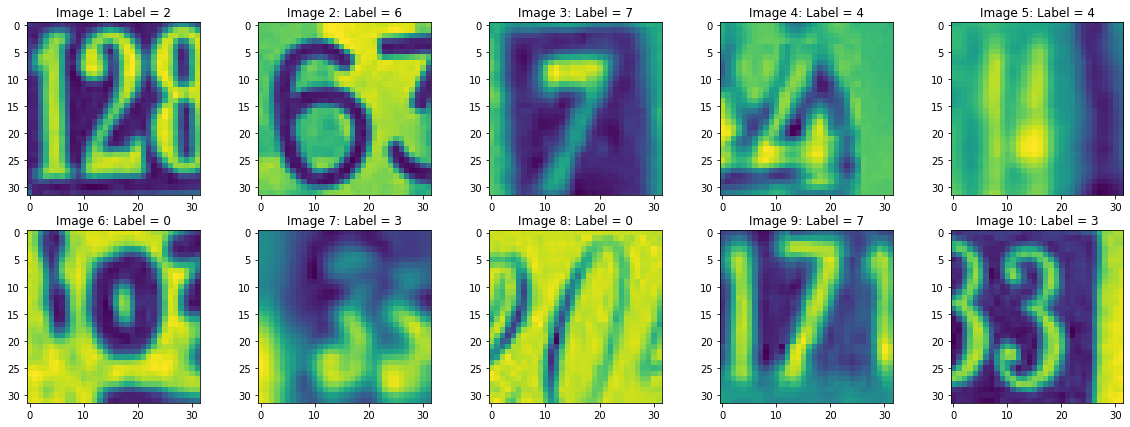

In [6]:
# Creating plot
fig = plt.figure(figsize=(20,7))


# Creating subplots for each of the 10 images and their labels
for i in range(10):
    fig.add_subplot(2, 5, i+1)  # create subplot in position i+1, where position is between 2 rows and 5 columns
    plt.imshow(X_train[i])  # display image
    plt.title(f'Image {i+1}: Label = {y_train[i]}')  # add title to each image with corresponding label

## **Data preparation**

- Print the shape and the array of pixels for the first image in the training dataset.
- Normalize the train and the test dataset by dividing by 255.
- Print the new shapes of the train and the test dataset.
- One-hot encode the target variable.

In [7]:
print('Shape of first image: ',X_train[0].shape)
print(X_train[0])

Shape of first image:  (32, 32)
[[ 33.0704  30.2601  26.852  ...  71.4471  58.2204  42.9939]
 [ 25.2283  25.5533  29.9765 ... 113.0209 103.3639  84.2949]
 [ 26.2775  22.6137  40.4763 ... 113.3028 121.775  115.4228]
 ...
 [ 28.5502  36.212   45.0801 ...  24.1359  25.0927  26.0603]
 [ 38.4352  26.4733  23.2717 ...  28.1094  29.4683  30.0661]
 [ 50.2984  26.0773  24.0389 ...  49.6682  50.853   53.0377]]


### **Normalize the train and the test data**

In [8]:
# # Dividing all image matrices by 255
# X_train_norm = [i/255 for i in X_train] 
# X_test_norm = [i/255 for i in X_test]

# Reshaping image matrices into a single array > Required for later step when input needs to be 1024
X_train = np.reshape(X_train, (len(X_train),len(X_train[0])*len(X_train[0][0])) )  # New shape = (num images, img length * img width)
X_test = np.reshape(X_test, (len(X_test),len(X_test[0])*len(X_test[0][0])) )

# Normalizing value of each image 
X_train = X_train/255
X_test = X_test/255

Print the shapes of Training and Test data

In [9]:
# print(len(X_train_norm), len(X_train_norm[0]), len(X_train_norm[0][0]))
# print(len(X_test_norm), len(X_test_norm[0]), len(X_test_norm[0][0]))

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

X_train shape:  (42000, 1024)
X_test shape:  (18000, 1024)


### **One-hot encode output**

In [10]:
# Representing label values as binary column values
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

**Observation:** Each image is 32x32 pixels, which is good since we don't have to normalize the image sizes. The values of the image pixels are normalized by dividing by 255 (max value of the RGB pixel value) which ensures all values are >=0 or <=1. Initially, I did not reshape the datasets, however I did so after realizing a later step requires the input to be a 1 dimensional array. The resulting datasets contain the same number of images but are now only single arrays of 32x32 length. Finally, the label train and test sets are one-hot encoded, meaning the label values are represented in binary column values rather than categorical numbers. These steps are important to ensure minimizing unwanted affects of non-important features in the modeling process.


## **Model Building**

Now that we have done the data preprocessing, let's build an ANN model.

### Fix the seed for random number generators

In [11]:
tf.random.set_seed(35)  # Fixing seed 35 to tf
np.random.seed(35)  # Fixing seed 35 to np

### **Model Architecture**
- Write a function that returns a sequential model with the following architecture:
 - First hidden layer with **64 nodes and the relu activation** and the **input shape = (1024, )**
 - Second hidden layer with **32 nodes and the relu activation**
 - Output layer with **activation as 'softmax' and number of nodes equal to the number of classes, i.e., 10**
 - Compile the model with the **loss equal to categorical_crossentropy, optimizer equal to Adam(learning_rate = 0.001), and metric equal to 'accuracy'**. Do not fit the model here, just return the compiled model.
- Call the nn_model_1 function and store the model in a new variable. 
- Print the summary of the model.
- Fit on the train data with a **validation split of 0.2, batch size = 128, verbose = 1, and epochs = 20**. Store the model building history to use later for visualization.

### **Build and train an ANN model as per the above mentioned architecture.**

In [12]:
# Function for ANN1 model
def ANN1():
    model = Sequential()  # Create sequential model
    
    model.add(Dense(64, input_shape=(1024,), activation='relu'))  # First hidden layer
    model.add(Dense(32, activation='relu'))  # Second hidden layer
    model.add(Dense(10, activation='softmax'))  # Output layer
    
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])  # Compiling model
    
    return model


# Calling ANN1 model
ANN_1 = ANN1()

# ANN1 model summary
ANN_1.summary()

# ANN1 model fitting
ANN_1_hist = ANN_1.fit(x=X_train, y=y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2)

C:\Users\eddie\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,010 (265.66 KB)

 Trainable params: 68,010 (265.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1130 - loss: 2.3013 - val_accuracy: 0.1340 - val_loss: 2.2429
Epoch 2/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1428 - loss: 2.2311 - val_accuracy: 0.1913 - val_loss: 2.1562
Epoch 3/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1869 - loss: 2.1400 - val_accuracy: 0.1892 - val_loss: 2.1253
Epoch 4/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1878 - loss: 2.1185 - val_accuracy: 0.1898 - val_loss: 2.1132
Epoch 5/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1926 - loss: 2.1112 - val_accuracy: 0.1889 - val_loss: 2.1119
Epoch 6/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1942 - loss: 2.1080 - val_accuracy: 0.1920 - val_loss: 2.1049
Epoch 7/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1974 - loss: 2.1037 - val_accuracy: 0.1942 - val_loss: 2.0990
Epoch 8/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1993 - loss: 2.1000 - val_accuracy: 0.

### **Plot the Training and Validation Accuracies and write down your Observations.**

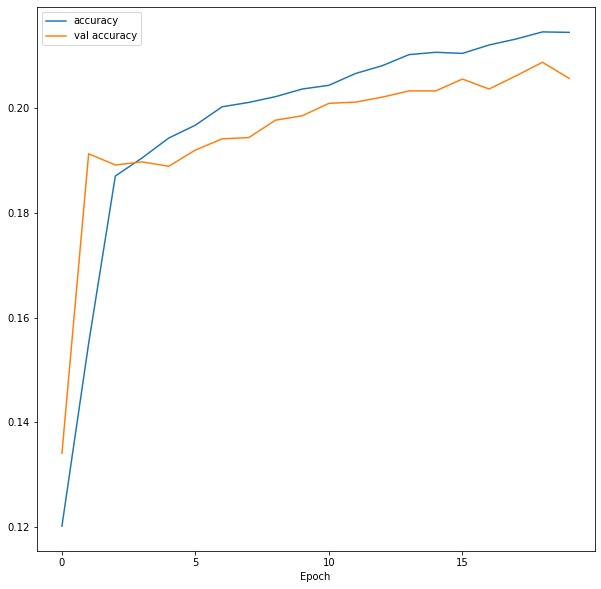

In [13]:
plt.figure(figsize=(10,10))  # Setting figure size
plt.plot(ANN_1_hist.history['accuracy'], label = 'accuracy')  # Plotting accuracy
plt.plot(ANN_1_hist.history['val_accuracy'], label = 'val accuracy')  # Plotting val-accuracy
plt.xlabel('Epoch')  # Labeling xaxis labels
plt.xticks([i*5 for i in range(4)])  # Setting x axis values
plt.legend()  # Showing legend labels

**Observations:** While the model appears nice on the graph, if we look closer at the values we see the accuracy barely breaks the 25% mark, which is quite terrible if we wanted to deploy this for real use. There is definitely room to improve this model, however we are on a good track since there is clear indication that the model accuracy increases with each epoch, and shows potential growth beyond 20epochs. One approach could try to increase the number of epochs and see if that results in a better model. In this case, it might be plausible since we don't have an extremely large amount of data and our model is relatively simple, so it will not take much time or resource to incresae epochs. However, it may be more fitting to modify the model itself, which is what the next model iteration will do. Finally, it is a good sign that the accuracy and validation accuracy are very similar because it indicates that our model performs as expected, where the training data and new data are labeled with about the same accuracy.

Let's build one more model with higher complexity and see if we can improve the performance of the model. 

First, we need to clear the previous model's history from the Keras backend. Also, let's fix the seed again after clearing the backend.

In [14]:
backend.clear_session()  # Clearing keras model backend from previous session

tf.random.set_seed(35)  # Fixing seed 35 to tf
np.random.seed(35)  # Fixing seed 35 to np

### **Second Model Architecture**
- Write a function that returns a sequential model with the following architecture:
 - First hidden layer with **256 nodes and the relu activation** and the **input shape = (1024, )**
 - Second hidden layer with **128 nodes and the relu activation**
 - Add the **Dropout layer with the rate equal to 0.2**
 - Third hidden layer with **64 nodes and the relu activation**
 - Fourth hidden layer with **64 nodes and the relu activation**
 - Fifth hidden layer with **32 nodes and the relu activation**
 - Add the **BatchNormalization layer**
 - Output layer with **activation as 'softmax' and number of nodes equal to the number of classes, i.e., 10**
 -Compile the model with the **loss equal to categorical_crossentropy, optimizer equal to Adam(learning_rate = 0.0005), and metric equal to 'accuracy'**. Do not fit the model here, just return the compiled model.
- Call the nn_model_2 function and store the model in a new variable.
- Print the summary of the model.
- Fit on the train data with a **validation split of 0.2, batch size = 128, verbose = 1, and epochs = 30**. Store the model building history to use later for visualization.

### **Build and train the new ANN model as per the above mentioned architecture**

In [15]:
# Function for ANN1 model
def ANN2():
    model = Sequential()  # Create sequential model
    
    model.add(Dense(256, input_shape=(1024,), activation='relu')) # First hidden layer
    model.add(Dense(128, activation='relu')) # Second hidden layer
    model.add(Dropout(rate=0.2)) # Third hidden layer
    model.add(Dense(64, activation='relu')) # Fourth hidden layer
    model.add(Dense(32, activation='relu')) # Fifth hidden layer
    model.add(BatchNormalization()) # BatchNorm layer
    model.add(Dense(10, activation='softmax')) # Second hidden layer
    
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), metrics=['accuracy']) # Compiling model
    
    return model


# Calling ANN1 model
ANN_2 = ANN2()

# ANN1 model summary
ANN_2.summary()

# ANN1 model fitting
ANN_2_hist = ANN_2.fit(x=X_train, y=y_train, batch_size=128, epochs=30, verbose=1, validation_split=0.2)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 306,090 (1.17 MB)

 Trainable params: 306,026 (1.17 MB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1000 - loss: 2.4101 - val_accuracy: 0.1021 - val_loss: 2.3037
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1168 - loss: 2.2991 - val_accuracy: 0.1352 - val_loss: 2.2520
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2794 - loss: 1.9958 - val_accuracy: 0.4713 - val_loss: 1.6388
Epoch 4/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4872 - loss: 1.5181 - val_accuracy: 0.5823 - val_loss: 1.3056
Epoch 5/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5768 - loss: 1.2981 - val_accuracy: 0.6236 - val_loss: 1.1821
Epoch 6/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6208 - loss: 1.1831 - val_accuracy: 0.6354 - val_loss: 1.1330
Epoch 7/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6500 - loss: 1.1091 - val_accuracy: 0.6611 - val_loss: 1.0675
Epoch 8/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6659 - loss: 1.0563 - val_accuracy: 0.

### **Plot the Training and Validation Accuracies and write down your Observations.**

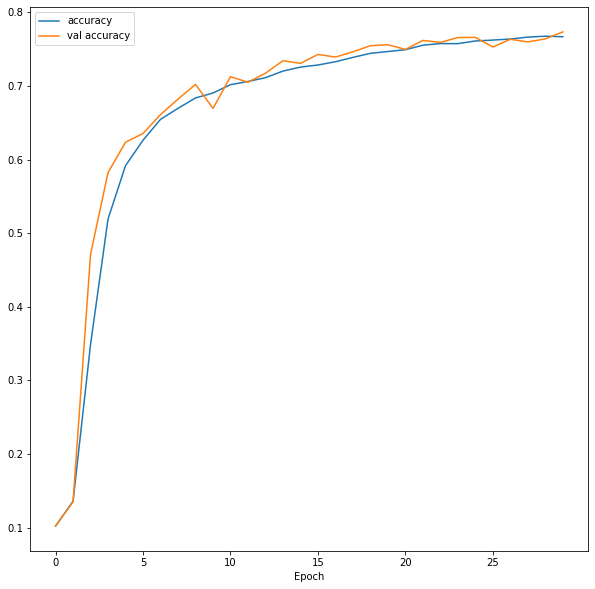

In [16]:
plt.figure(figsize=(10,10))  # Setting figure size
plt.plot(ANN_2_hist.history['accuracy'], label = 'accuracy')  # Plotting accuracy
plt.plot(ANN_2_hist.history['val_accuracy'], label = 'val accuracy')  # Plotting val-accuracy
plt.xlabel('Epoch')  # Labeling xaxis labels
plt.xticks([i*5 for i in range(6)])  # Setting x axis values
plt.legend()  # Showing legend labels

**Observations:** This model looks much better than the previous, and we see both the accuracy and validation accuracy nearly approach 80%. Furthermore, the accuracy and validation accuracy lines are nearly identical through each epoch, which is a great sign that that model is appropriatly trained, neither over or under fit. In other words, the model is able to just as accurately label new images that were not used to train the model. The Validation accuracy looks a little rugged after about epoch 5, but this can be attributed to the fact that new data is being fed to the model, which will introduce the probability of errors, and thus is not a cause of concern for this model. Overall, this model looks great and healthy, and while the accuracy is still not spectacular, this is surely usable in many cases where the highest accuracy isn't necassary. Finally, it appears that maybe increasing the number of epochs could increase the model accuracy, since it appears that the accuracy continues to show positive growth even as it approaches the final epoch. Since this model is quite simple, and computation time is low (~1 sec per epoch), this can theoretically be tested easily.

## **Predictions on the test data**

- Make predictions on the test set using the second model.
- Print the obtained results using the classification report and the confusion matrix.
- Final observations on the obtained results.

In [20]:
# Predicting X_test dataset - Converting to singular labels for later steps
ANN2_test = ANN_2.predict(X_test)
ANN_2test_ = np.argmax(ANN2_test, axis = -1)

y_test_ = np.argmax(y_test, axis = -1)

563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


**Note:** Earlier, we noticed that each entry of the target variable is a one-hot encoded vector but to print the classification report and confusion matrix, we must convert each entry of y_test to a single label.

### **Print the classification report and the confusion matrix for the test predictions. Write your observations on the final results.**

              precision    recall  f1-score   support

           0       0.73      0.84      0.78      1814
           1       0.81      0.78      0.80      1828
           2       0.79      0.80      0.79      1803
           3       0.78      0.71      0.74      1719
           4       0.85      0.81      0.83      1812
           5       0.80      0.73      0.76      1768
           6       0.80      0.74      0.77      1832
           7       0.80      0.84      0.82      1808
           8       0.80      0.68      0.73      1812
           9       0.66      0.82      0.73      1804

    accuracy                           0.78     18000
   macro avg       0.78      0.78      0.78     18000
weighted avg       0.78      0.78      0.78     18000



<AxesSubplot:>

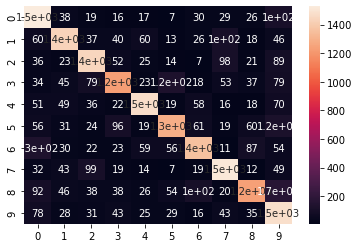

In [27]:
print(classification_report(y_test_, ANN_2test_))  # Classficiation Report

confusion = confusion_matrix(y_test_, ANN_2test_)
sns.heatmap(confusion, annot = True)  # Confusion matrix


**Final Observations:** The classification report shows relatively healthy numbers, where generally all the labels had an 80%+ accuracy rate. 0 and 9 had the lowest accuracies, and when cross referencing with the confusion matrix, this makes sense. It appears that 0 is often mislabeled as 6 quite frequently, and 9 is mislabeled as 0, 5 and 8 quite frequently. These numbers do often look similar to each other, and thus there may need to be further training or development to ensure the model is adequetly identifying unique features that better differentiate between these similar-looking numbers. The confusion matrix overall looks very good, where the diagonal contains the lightest colors and largest values, which indicates the correct labeling for the corresponding number, and all the other squares are dark with smaller numbers, which indicates the number of False labeling for each image (True values are on the X-axis, Predicted are on the Y-axis). Overall, this model looks very good, and with some extra tweaking it can be fine-tuned to minimize the mislabeling that frequently occurs in 0 and 9 to make it even better.

## **Using Convolutional Neural Networks**

### **Load the dataset again and split the data into the train and the test dataset.**

In [28]:
raw_data = h5py.File('SVHN_single_grey1.h5', 'r')  # Reading and saving .h5 file  


print(raw_data.keys())  # Checking the number of folders in the .h5 file


# Saving X test and train datasets
X_test = raw_data['X_test']

X_train = raw_data['X_train']


# Saving y test and train datasets
y_test = raw_data['y_test']

y_train = raw_data['y_train']

<KeysViewHDF5 ['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']>


Check the number of images in the training and the testing dataset.

In [29]:
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

42000 42000
18000 18000


**Observation:** We are back to the original, lovely dataset from the raw files. The training files lengths are equal and so are the testing files, indicating no missing image-label pairs. This is also proof that the variables containing the data have been reset back to the original, since they were modified previously in the ANN modeling.


## **Data preparation**

- Print the shape and the array of pixels for the first image in the training dataset.
- Reshape the train and the test dataset because we always have to give a 4D array as input to CNNs.
- Normalize the train and the test dataset by dividing by 255.
- Print the new shapes of the train and the test dataset.
- One-hot encode the target variable.

In [30]:
print('Shape of first image: ',X_train[0].shape)
print(X_train[0])

Shape of first image:  (32, 32)
[[ 33.0704  30.2601  26.852  ...  71.4471  58.2204  42.9939]
 [ 25.2283  25.5533  29.9765 ... 113.0209 103.3639  84.2949]
 [ 26.2775  22.6137  40.4763 ... 113.3028 121.775  115.4228]
 ...
 [ 28.5502  36.212   45.0801 ...  24.1359  25.0927  26.0603]
 [ 38.4352  26.4733  23.2717 ...  28.1094  29.4683  30.0661]
 [ 50.2984  26.0773  24.0389 ...  49.6682  50.853   53.0377]]


Reshape the dataset to be able to pass them to CNNs. Remember that we always have to give a 4D array as input to CNNs

In [32]:
X_train = np.reshape(X_train, (len(X_train), len(X_train[0]), len(X_train[0][0]), 1))  # New shape = (num images, img length, img width, 1)
X_test = np.reshape(X_test, (len(X_test), len(X_test[0]), len(X_test[0][0]), 1))

Normalize inputs from 0-255 to 0-1

In [34]:
# Normalizing by dividing by 255 (max RGB pixel value)
X_train = X_train/255
X_test = X_test/255

Print New shape of Training and Test

In [35]:
print('X_train shape: ',X_train.shape)
print('X_test shape: ',X_test.shape)

X_train shape:  (42000, 32, 32, 1)
X_test shape:  (18000, 32, 32, 1)


### **One-hot encode the labels in the target variable y_train and y_test.**

In [36]:
# One-hot encoding: each label is represented as a binary sequence of columns.
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(y_train)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


**Observation:** This is very similar to what we have already seen before, with the exception that we were given a hint that CNN's needed a 4D shape, which is why we added the extra dimension when reshaping. Normalizing the pixel values by dividing by 255, and finally one-hot encoding the labels. Again, these steps are completed to ensure minimal unwanted affects from unwanted features when modeling.


## **Model Building**

Now that we have done data preprocessing, let's build a CNN model.
Fix the seed for random number generators

In [37]:
tf.random.set_seed(35)  # Fixing seed 35 to tf
np.random.seed(35)  # Fixing seed 35 to np

### **Model Architecture**
- **Write a function** that returns a sequential model with the following architecture:
 - First Convolutional layer with **16 filters and the kernel size of 3x3**. Use the **'same' padding** and provide the **input shape = (32, 32, 1)**
 - Add a **LeakyRelu layer** with the **slope equal to 0.1**
 - Second Convolutional layer with **32 filters and the kernel size of 3x3 with 'same' padding**
 - Another **LeakyRelu** with the **slope equal to 0.1**
 - A **max-pooling layer** with a **pool size of 2x2**
 - **Flatten** the output from the previous layer
 - Add a **dense layer with 32 nodes**
 - Add a **LeakyRelu layer with the slope equal to 0.1**
 - Add the final **output layer with nodes equal to the number of classes, i.e., 10** and **'softmax' as the activation function**
 - Compile the model with the **loss equal to categorical_crossentropy, optimizer equal to Adam(learning_rate = 0.001), and metric equal to 'accuracy'**. Do not fit the model here, just return the compiled model.
- Call the function cnn_model_1 and store the output in a new variable.
- Print the summary of the model.
- Fit the model on the training data with a **validation split of 0.2, batch size = 32, verbose = 1, and epochs = 20**. Store the model building history to use later for visualization.

### **Build and train a CNN model as per the above mentioned architecture.**

In [44]:
def CNN1():
    model = Sequential() # Create sequential model
    
    model.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', input_shape=(32,32,1))) # First Convolution layer
    model.add(LeakyReLU(negative_slope=0.1)) # LeakyReLU layer
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same')) # Second Convolution layer
    model.add(LeakyReLU(negative_slope=0.1)) # LeakyReLU layer
    model.add(MaxPooling2D(pool_size=(2,2))) # MaxPooling layer
    model.add(Flatten()) # Flatten layer
    model.add(Dense(32)) # Dense layer
    model.add(LeakyReLU(negative_slope=0.1)) # LeakyReLU layer
    model.add(Dense(10, activation='softmax')) # Output layer
    
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])
    
    return model


# Calling CNN1 model
CNN_1 = CNN1()

# CNN1 model summary
CNN_1.summary()

# CNN1 model fitting
CNN_1_hist = CNN_1.fit(x=X_train, y=y_train, batch_size=32, epochs=20, verbose=1, validation_split=0.2)        

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │       262,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 267,306 (1.02 MB)

 Trainable params: 267,306 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.4037 - loss: 1.6808 - val_accuracy: 0.8245 - val_loss: 0.6037
Epoch 2/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8343 - loss: 0.5665 - val_accuracy: 0.8535 - val_loss: 0.5222
Epoch 3/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8661 - loss: 0.4595 - val_accuracy: 0.8605 - val_loss: 0.4913
Epoch 4/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8832 - loss: 0.3986 - val_accuracy: 0.8646 - val_loss: 0.4832
Epoch 5/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8965 - loss: 0.3532 - val_accuracy: 0.8667 - val_loss: 0.4790
Epoch 6/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9095 - loss: 0.3129 - val_accuracy: 0.8682 - val_loss: 0.4763
Epoch 7/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9193 - loss: 0.2773 - val_accuracy: 0.8664 - val_loss: 0.4991
Epoch 8/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9278 - loss: 0.2458 - 

### **Plot the Training and Validation Accuracies and Write your observations.**

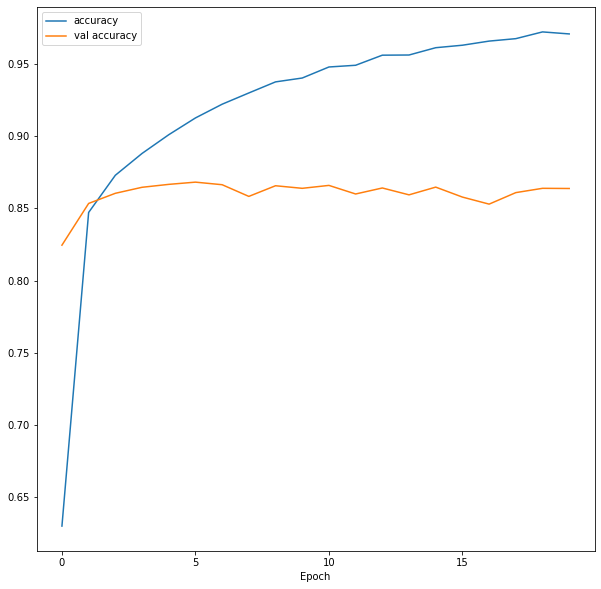

In [45]:
plt.figure(figsize=(10,10))  # Setting figure size
plt.plot(CNN_1_hist.history['accuracy'], label = 'accuracy')  # Plotting accuracy
plt.plot(CNN_1_hist.history['val_accuracy'], label = 'val accuracy')  # Plotting val-accuracy
plt.xlabel('Epoch')  # Labeling xaxis labels
plt.xticks([i*5 for i in range(4)])  # Setting x axis values
plt.legend()  # Showing legend labels

**Observations:** Based on the accuracy plots, this first CNN model appears to be better than the second ANN model. The validation accuracy capped at just above 85%, which is better than the former model. However, while the accuracy continued to rise through each epoch, the validation accuracy remained static, and at times even showed signs of becoming worse with increased epochs, specifically theres noticeable decrease in accuracy around epoch 5 onwards. Especially with accuracy nearing 100%, this can be an indication that the model is overfit. While the validation accuracy is still larger than the previous ANN model, I would still be wary of using it because there is less certainty that the model is suitable for labeling new data. Right now it seems we have good results, but ultimately this could be luck of randomness, and since our model does not appear to follow the trend on the training accuracy, it is definitely an area of worry. One interesting observation is that the time for each epoch completion dramatically increased in comparison to the ANN models, taking about 6 times as long to complete. For this purpose this is okay, since we are not working with very large datasets or incredibly complex models, but this could be a warning that testing this model will be more resource expensive down the line.

Let's build another model and see if we can get a better model with generalized performance.

First, we need to clear the previous model's history from the Keras backend. Also, let's fix the seed again after clearing the backend.

In [46]:
backend.clear_session()  # Clearing keras model backend from previous session

tf.random.set_seed(35)  # Fixing seed 35 to tf
np.random.seed(35)  # Fixing seed 35 to np

### **Second Model Architecture**

- Write a function that returns a sequential model with the following architecture:
 - First Convolutional layer with **16 filters and the kernel size of 3x3**. Use the **'same' padding** and provide the **input shape = (32, 32, 1)**
 - Add a **LeakyRelu layer** with the **slope equal to 0.1**
 - Second Convolutional layer with **32 filters and the kernel size of 3x3 with 'same' padding**
 - Add **LeakyRelu** with the **slope equal to 0.1**
 - Add a **max-pooling layer** with a **pool size of 2x2**
 - Add a **BatchNormalization layer**
 - Third Convolutional layer with **32 filters and the kernel size of 3x3 with 'same' padding**
 - Add a **LeakyRelu layer with the slope equal to 0.1**
 - Fourth Convolutional layer **64 filters and the kernel size of 3x3 with 'same' padding** 
 - Add a **LeakyRelu layer with the slope equal to 0.1**
 - Add a **max-pooling layer** with a **pool size of 2x2**
 - Add a **BatchNormalization layer**
 - **Flatten** the output from the previous layer
 - Add a **dense layer with 32 nodes**
 - Add a **LeakyRelu layer with the slope equal to 0.1**
 - Add a **dropout layer with the rate equal to 0.5**
 - Add the final **output layer with nodes equal to the number of classes, i.e., 10** and **'softmax' as the activation function**
 - Compile the model with the **categorical_crossentropy loss, adam optimizers (learning_rate = 0.001), and metric equal to 'accuracy'**. Do not fit the model here, just return the compiled model.
- Call the function cnn_model_2 and store the model in a new variable.
- Print the summary of the model.
- Fit the model on the train data with a **validation split of 0.2, batch size = 128, verbose = 1, and epochs = 30**. Store the model building history to use later for visualization.

### **Build and train the second CNN model as per the above mentioned architecture.**

In [47]:
def CNN2():
    model = Sequential() # Create sequential model
    
    model.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', input_shape=(32,32,1))) # First Convolution layer
    model.add(LeakyReLU(negative_slope=0.1)) # LeakyReLU layer
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same')) # Second Convolution layer
    model.add(LeakyReLU(negative_slope=0.1)) # LeakyReLU layer
    model.add(MaxPooling2D(pool_size=(2,2))) # MaxPooling layer
    model.add(BatchNormalization()) # BatchNorm layer
    model.add(Flatten()) # Flatten layer
    model.add(Dense(32)) # Dense layer
    model.add(LeakyReLU(negative_slope=0.1)) # LeakyReLU layer
    model.add(Dropout(rate=0.5)) # Dropout layer
    model.add(Dense(10, activation='softmax')) # Output layer
    
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])
    
    return model


# Calling CNN1 model
CNN_2 = CNN2()

# CNN2 model summary
CNN_2.summary()

# CNN2 model fitting
CNN_2_hist = CNN_2.fit(x=X_train, y=y_train, batch_size=128, epochs=30, verbose=1, validation_split=0.2)        

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       262,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 267,434 (1.02 MB)

 Trainable params: 267,370 (1.02 MB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.2542 - loss: 2.0513 - val_accuracy: 0.7682 - val_loss: 1.8367
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.6920 - loss: 0.9579 - val_accuracy: 0.8311 - val_loss: 0.7719
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.7500 - loss: 0.7916 - val_accuracy: 0.8367 - val_loss: 0.5595
Epoch 4/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.7811 - loss: 0.7033 - val_accuracy: 0.8398 - val_loss: 0.5541
Epoch 5/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.7934 - loss: 0.6663 - val_accuracy: 0.8396 - val_loss: 0.5684
Epoch 6/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8008 - loss: 0.6352 - val_accuracy: 0.8501 - val_loss: 0.5193
Epoch 7/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8097 - loss: 0.6008 - val_accuracy: 0.8381 - val_loss: 0.5558
Epoch 8/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8167 - loss: 0.5860 - val_accu

### **Plot the Training and Validation accuracies and write your observations.**

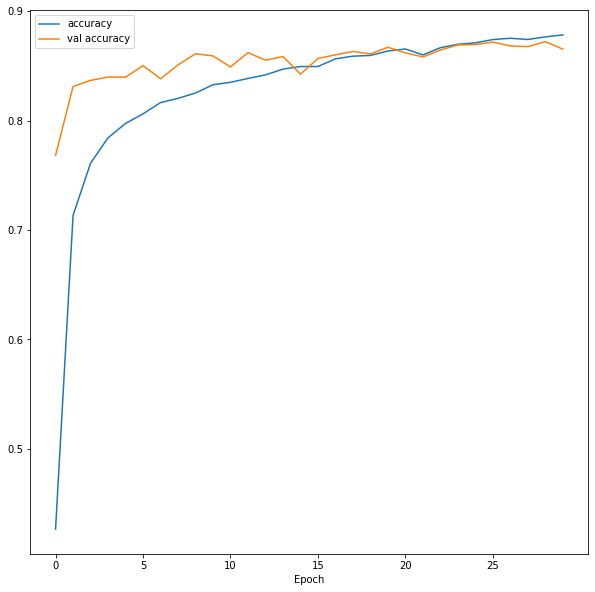

In [48]:
plt.figure(figsize=(10,10))  # Setting figure size
plt.plot(CNN_2_hist.history['accuracy'], label = 'accuracy')  # Plotting accuracy
plt.plot(CNN_2_hist.history['val_accuracy'], label = 'val accuracy')  # Plotting val-accuracy
plt.xlabel('Epoch')  # Labeling xaxis labels
plt.xticks([i*5 for i in range(6)])  # Setting x axis values
plt.legend()  # Showing legend labels

**Observations:** The most apparent visual compared to CNN1 is that the accuracy and validation accuracy converge at nearly the same values by epoch 10, and remain relatively equal until the last epoch. Also, the accuracy is just slightly above 90% and not approaching 100% like the previous model. These two observations are a great sign that that this model is neither over or under fit. Overall, because the validation accuracy is higher than the previous model, and because the model appears to be well fit, this model is better than the previous CNN model. The training for this model was also slightly longer than the previous model, which further adds to the speculation that modifications and testing for CNN is likely very computationally and resource expensive if we had more complex modeling or more data.

## **Predictions on the test data**

- Make predictions on the test set using the second model.
- Print the obtained results using the classification report and the confusion matrix.
- Final observations on the obtained results.

### **Make predictions on the test data using the second model.** 

In [51]:
# Predicting X_test dataset
CNN2_test = CNN_2.predict(X_test)
CNN2_test_ = np.argmax(CNN2_test, axis = -1)

# Converting to singular labels for later steps
y_test_ = np.argmax(y_test, axis = -1)

563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


**Note:** Earlier, we noticed that each entry of the target variable is a one-hot encoded vector, but to print the classification report and confusion matrix, we must convert each entry of y_test to a single label.

In [1]:
print(classification_report(y_test_, CNN2_test_))  # Classficiation Report

confusion = confusion_matrix(y_test_, CNN2_test_)
sns.heatmap(confusion, annot = True)  # Confusion matrix

NameError: name 'classification_report' is not defined

### **Write your final observations on the performance of the model on the test data.**

**Final Observations:** The CNN2 model shows great results in both the classification report and confusion matrix. All the number labels have an accuracy of 83% or larger (and most of them are almost 90%+) which means the model was able to adequatley identify unique features to seperate each number on a consistent basis. This is further seen in the confusion matrix where the diagonal (representing the correct labeling) is all light with large numbers, while everything else is overwhelmingly dark with low numbers, indicating that relatively low mislabeling occured. Interestingly, it appears that the most common error was 1 being mislabeled as 7, but even these errors are about 100, which is a small fraction of error compared to the total number of images in the set. Overall, this is a great model where we can also have confidence in it's performence with new data to predict.

Comparing the ANN and CNN models in this context, it appears that CNN is undoubtedly superior in terms of accuracy, but suffers from more intensive resource and computation requirement. This may lead to issues with larger datasets or developing models later. It may be a good idea to start with developing ANN, or similarly simple models, first and move on to more complex modeling if the results are not satisfactory. Furthermore, there was a lack of data understanding in this assignment. For example, it would have been a good idea to see the distribution of image labels provided in the dataset to ensure there aren't too little of some labels, which could affect model quality. Regardless, this was a very fun assignment and I am glad i chose Deep Learning as my route.